In [0]:
!pip install colorama mnist 

import os

from google.colab import drive
import matplotlib.pyplot as plt
import mnist
import numpy as np
import json 


np.random.seed(420)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Pre-Processing


*  We are using the MNIST dataset in order to train and test our model.  
*  MNIST is database of handwritten digits , has a training set of 60,000 examples, and a test set of 10,000 examples. 
*  The digits have been size-normalized and centered in a fixed-size image.

In [0]:
train_img = mnist.train_images()
train_labels = mnist.train_labels()

print(train_img.shape,train_labels.shape)

(60000, 28, 28) (60000,)


**The input data** of the mnist dataset is one huge bitmap containing all 60000 images one after the other. The dataset needs to be sliced to get each image as a sepparate matrix so that we can feed it to the first layer of the NN. 


In [0]:
X = np.array(train_img).reshape(len(train_img), 28 * 28) 
print(X.shape)

(60000, 784)


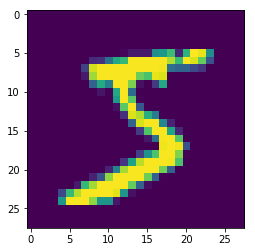

In [0]:
first_image = np.array(X[0], dtype='float')
plt.imshow(first_image.reshape(28, 28))
plt.show()

  **The output data** of the mnist dataset is a long array of single digits representing the correct digit that should be predicted by the model. However,  this data needs to be encoded in a matrix format. One-hot encoding takes care of that. 

In [0]:
def one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

The one_hot function provides a simple interface to convert class label integers into an array where each unique label is represented as a column in the new array.


In [0]:
print(train_labels[0], '>',  one_hot(train_labels[0], 10))

5 > [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [0]:
Y = one_hot(train_labels, 10)
print(train_labels.shape, '>', Y.shape)

(60000,) > (60000, 10)


# Parameter selection

### Number of Nodes

In [0]:
s_x = X.shape[1]
s_y = Y.shape[1]
s_h = 250
print('IN:', s_x, 'HIDDEN:', s_h, 'OUT:', s_y)

IN: 784 HIDDEN: 250 OUT: 10


### Weights

Weights  represent the strength of the connection between units.
* If the weight from node 1 to node 2 has greater magnitude, it means that neuron 1 has greater influence over neuron 2. 
* A weight brings down the importance of the input value. 
* Weights near zero means changing this input will not change the output.
* Negative weights mean increasing this input will decrease the output.
* A weight decides how much influence the input will have on the output.

To apply the chain rule successfully The shape of the weight matrices needs to match the shape of the input data. 
hem with random normally distributed data

In [0]:
s_weight1 = (s_x, s_h)
s_weight2 = (s_h, s_y)
print(s_weight1, s_weight2)

(784, 250) (250, 10)


In [0]:
limit_1 = np.sqrt(6 / (s_x + s_h))
limit_2 = np.sqrt(6 / (s_h + s_y))

print(-limit_1, limit_1)
print(-limit_2, limit_2)

-0.07617550741785384 0.07617550741785384
-0.15191090506255 0.15191090506255


Something something limit 

In [0]:
w1 = np.random.uniform(-limit_1, limit_1, size=s_weight1)
w2 = np.random.uniform(-limit_2, limit_2, size=s_weight2)

### Bias 

The bias is an extra input to neurons and it is always 1, and has it’s own connection weight. 
This makes sure that even when all the inputs are none (all 0’s) there’s gonna be an activation in the neuron or i think the reverse in this case

In [0]:
s_bias1 = (1, s_h)
s_bias2 = (1, s_y)
print(s_bias1, s_bias2)

(1, 250) (1, 10)


In [0]:
b1 = np.zeros(shape=s_bias1)
b2 = np.zeros(shape=s_bias2)

### Model

*  Gets initialised with the parameters
*  Ensures safe data update
*  gets updated in memory
* can be saved to a file after training



In [0]:
class model(object):

    def __init__(self, W1, B1, W2, B2):
        self.__w1 = W1
        self.__b1 = B1
        self.__w2 = W2
        self.__b2 = B2

    def update(self, d_w1, d_b1, d_w2, d_b2, learning_rate = 1.2):
        self.__w1 = self.__w1 - learning_rate * d_w1
        self.__w2 = self.__w2 - learning_rate * d_w2
        self.__b1 = self.__b1 - learning_rate * d_b1
        self.__b2 = self.__b2 - learning_rate * d_b2

    def w1(self): return self.__w1
    def w2(self): return self.__w2
    def b1(self): return self.__b1
    def b2(self): return self.__b2

In [0]:
_model = model(w1, b1, w2, b2)

# Functions

## Activation


![alt text](https://cdn-images-1.medium.com/max/1000/1*XxxiA0jJvPrHEJHD4z893g.png)
*  **ReLU** is the most used activation function in the world right now. 
*  Using a sigmoid or tanh will cause almost all neurons to fire in an analog way 
    * That means almost all activations will be processed to describe the output of a network.
    * In other words the activation is dense. This is costly. 
    * We would ideally want a few neurons in the network to not activate and thereby making the activations sparse and efficient.
* However, there's a problem -->  For activations in that region of ReLu, gradient will be 0 because of which the weights will not get adjusted during descent --> Dying ReLu
* We solve this by limiting the weights and using clipping


In [0]:
def ReLU(x, deriv=False):
    if deriv:
        return (x > 0).astype(float)
    return x * (x > 0).astype(float)

## Summation



* **Softmax**  is a function that takes as input a vector of X real numbers, and normalizes it into a probability distribution consisting of X probabilities
* Basically we apply the standard exponential function to each element of the input vector and normalize these values by dividing by the sum of all these exponentials
* Normalization ensures that the sum of the probabilities omponents of the output vector is 1

| Sigmoid  | Softmax   |
|---|---|
|  The probabilities sum will be 1|  The probabilities sum need not be 1.  |
|  Used in the different layers of neural networks. | Used as activation function while building neural network  |
|  The high value will have the higher probability than other values. | Used as activation function while building neural network  |


*   Basically, the sigmoid works best for binary classification, and softmax works best for multi-classification


In [0]:
def softmax(x):
    max_x = np.amax(x, 1, keepdims=True)

    normalized = x - max_x
    exponents = np.exp(normalized)
    return exponents/exponents.sum(1, keepdims=True)

## Cost
*  When we develop a model for probabilistic classification, we aim to map the model's inputs to probabilistic predictions.
* The model is trained by incrementally adjusting the model's parameters so that our predictions get closer and closer to ground-truth probabilities
* Cross-entropy is commonly used to quantify the difference between two probability distributions. 
* Usually the "true" distribution (the one that your machine learning algorithm is trying to match) is expressed in terms of a one-hot distribution.
  * we encoded the labels using one-hot in the data pre-processing part 
* Our model is based around the assumption that classes are mutually exclusive (eg. a digit cant' be a 6 and a 9 at the same time)
* Cross entropy 



In [0]:
def cross_entropy(a2, y):
    N = a2.shape[0]
    clipped = np.clip(a2, 1e-10, 1)
    
    return -1/N*np.sum(y * np.log(clipped))

# Feed-Forward

In [0]:
def forward_propagation(X, w1, b1, w2, b2):
    z1 = np.dot(X, w1) + b1
    a1 = ReLU(z1)
    
    z2 = np.dot(a1, w2) + b2
    a2 = softmax(z2)
    
    return a1, a2

# Back-Propagation

In [0]:
def backward_propagation(X, Y, W1, W2, A1, A2, b1, b2, clipping=False):
    dZ2 = A2 - Y
    db2 = dZ2
    dW2 = A1.T @ dZ2
    dA1 = dZ2 @ W2.T
    dZ1 = ReLU(A1, True) * dA1
    db1 = dZ1
    dW1 = X.T @ dZ1

    if clipping:
        dW1 = np.clip(dW1, -50, 50)
        dW2 = np.clip(dW2, -100, 100)

    return dW1, db1, dW2, db2

# Training

Before training, we have defined a method that uses MatPlotLib to graph the gradients, cost and weights as the model is trained

In [0]:
iterations = 50
graph_refresh_rate = 1
decimals = 4        

In [0]:
for i in range(iterations):
  w1 = _model.w1()
  w2 = _model.w2()
  b1 = _model.b1()
  b2 = _model.b2()

  a1, a2 = forward_propagation(X, w1, b1, w2, b2)
  cost = cross_entropy(a2, Y)
  
  dw1, db1, dw2, db2 = backward_propagation(X, Y, w1, w2, a1, a2, b1, b2)
  _model.update(dw1, db1, dw2, db2)
      
  if i % graph_refresh_rate == 0 and i > 0:
    cost = round(cost, decimals)
    w1_n = np.round_(np.linalg.norm(w1), decimals)
    w2_n = np.round_(np.linalg.norm(w2), decimals)
    
    print("i: {} / Cost: {} / W1: {} /  W2: {}".format(i ,cost, w1_n, w2_n))

i: 1 / Cost: 20.3706 / W1: 43557904.5258 /  W2: 29254024.4
i: 2 / Cost: 20.4266 / W1: 395208380237347.1 /  W2: 2242898224366225.5
i: 3 / Cost: 19.3889 / W1: 3.938981244192908e+20 /  W2: 8.025083481605251e+19
i: 4 / Cost: 0.1173 / W1: 9.561240840595252e+24 /  W2: 4.795807895028518e+26
i: 5 / Cost: 0.0971 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 6 / Cost: 0.084 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 7 / Cost: 0.0742 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 8 / Cost: 0.0666 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 9 / Cost: 0.0605 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 10 / Cost: 0.0555 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 11 / Cost: 0.0513 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 12 / Cost: 0.0477 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i: 13 / Cost: 0.0446 / W1: 1.9155713637450244e+28 /  W2: 1.3046670897941235e+27
i